# **Práctica #3: Regresión**

La tercer práctica consiste en predecir el valor de una variable a partir de un conjunto de variables predictoras en un dataset de venta de casas en Italia. La variable a predecir será el precio de una casa.

Se deberá realizar:
- La limpieza de los datos.
- Un análisis exploratorio de los datos.
- Una técnica de reducción de dimensionalidad.
- Extracción de características para crear por lo menos 2 atributos nuevos (que sean interesantes).
- Aplicar al menos dos técnicas de selección de características.
- Entrenar al menos 4 modelos de regresión diferentes (uno tiene que ser regresión lineal),
- Reportar el resultado de evaluación con una partición de los datos local.
- Reportar el resultado de evaluación con un conjunto de datos de prueba que se les será proporcionado dos días antes.
- Escribir una discusión y las conclusiones sobre el trabajo realizado.

Para dar inicio, importamos las librerías que vamos a utilizar en la práctica junto al dataset de entrenamiento

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
from umap import UMAP

In [2]:
train_df = pd.read_csv(f'train_housing_data_italy.csv', na_values=r'\N')


## Análisis exploratorio

Antes de comenzar a limpiar los datos, tendremos que analizar el *dataframe* para tomar la decisión de eliminar, cambiar o agregar datos.

In [3]:
train_df.head()

,timestamp,location,title,price,n_rooms,floor,mq,n_bathrooms,year_of_construction,availability,...,has_balcony,has_fireplace,has_alarm,has_air_conditioning,has_pool,has_parking,has_elevator,is_furnished,latitude,longitude
0,1.661114e+09,siculiana,"villa unifamiliare via campo spoto 38, siculiana",46000.0,4.0,NaN,85.0,2.0,NaN,not free / other,...,0,0,0,0,0,0,0,0,373.380.858,134.219.962
1,1.661114e+09,strongoli,"quadrilocale contrada tronga 211, tronca, stro...",120000.0,4.0,2.0,190.0,2.0,NaN,not free / other,...,0,0,0,0,0,0,0,0,392.639.586,170.520.257
2,1.661114e+09,zelbio,"bilocale buono stato, piano terra, zelbio",55000.0,2.0,NaN,85.0,1.0,NaN,not free / other,...,0,1,0,1,0,0,0,0,45.904.582,9.180.539
3,1.661114e+09,villamagna,"casa colonica, da ristrutturare, 319 m², villa...",130000.0,4.0,NaN,319.0,1.0,NaN,not free / other,...,0,0,0,0,0,0,0,0,423.332.946,142.368.079
4,1.661114e+09,vallefiorita,"appartamento corso italia, vallefiorita",30000.0,NaN,NaN,143.0,2.0,NaN,not free / other,...,0,0,0,1,0,0,0,0,38.776.385,16.461.003


In [4]:
train_df.isnull().sum()


timestamp                   0
location                    0
title                       0
price                   37478
n_rooms                 57848
floor                   69102
mq                       3889
n_bathrooms             13804
year_of_construction       10
availability                0
energy_class              648
status                      0
heating                     0
has_garage                  0
has_terrace                 0
has_garden                  0
has_balcony                 0
has_fireplace               0
has_alarm                   0
has_air_conditioning        0
has_pool                    0
has_parking                 0
has_elevator                0
is_furnished                0
latitude                   60
longitude                  60
dtype: int64

In [5]:
len(train_df.index)

213409

De lo anterior podemos notar que alrededor de una cuarta parte de los registros no tiene información en el campo *floor* y *n_rooms*. Además, una séptima parte no tiene información de *price* y solo tenemos tres opciones: rellenar los campos vacíos, eliminar sus registros o no hacer nada... Para fines de esta tarea, el objetivo será buscar un conjunto de datos de entrenamiento con 0 valores *null* ya sea rellenando campos vacíos o eliminando registros.

## Limpieza de datos

De antemano podemos ver que campos como la *latitud* y *longitud* refieren a la ubicación de la vivienda, al igual que la *localidad*, y con esto podemos pensar en una analogía en las colonias de Ensenada o en las ciudades de Baja California, que dependiendo de la ciudad o colonia los precios pueden ser más altos o bajos. De igual forma, las dimensiones de la vivienda, expresadas con *mq* (del italiano: metros quadratos) también van a influir en el precio de la vivienda, así como la antigüedad de la vivienda o si cuentan o no con ciertas amenidades. De momento la limpieza solo se limitará a eliminar registros, rellenar campos y a eliminar columnas. Dejaremos la creación de nuevos atributos para la **Extracción de características**.

Si elimináramos todos los registros que tienen al menos un campo *null*, estaríamos eliminando como mínimo una cuarta parte de los datos de entrenamiento, por lo que, para los campos *n_rooms*, *floor*, y *n_bathrooms* buscaremos rellenar los campos con algún valor estándar. Por otra parte, el campo *price* es lo que buscamos pronosticar, y agregar información ficticia puede perturbar nuestro modelo, por lo que simplemente eliminaremos esos registros que representan 1/7 del total de datos de entrenamiento. Para los campos de *latitude* y *longitude* no hay muchas implicaciones ya que son pocos registros, así que también serán eliminados. Por último, para *energy_class* y *year_of_construction* rellenaremos el campo, sin embargo, usaremos *year_of_construction* más adelante para obtener un nuevo atributo. 

Dicho todo lo anterior, consideraremos las siguientes reglas:
- *price*: eliminar el registro completo si *price* es vacío o si *price* < 10000 
- *n_rooms*: 1 si el campo es vacío
- *floor*: 1 si el campo es vacío
- *n_bathrooms*: 1 si el campo es vacío
- *year_of_construction*: 0 si el campo es vacío
- *energy_class*: other si el campo es vacío
- *latitude*: eliminar el registro completo si *latitude* es vacío
- *longitude*: eliminar el registro completo si *longitude* es vacío

In [6]:
train_df.drop(train_df[train_df['price'].isnull()].index, inplace=True)
train_df.drop(train_df[train_df['price'] < 10000].index, inplace=True)
train_df = train_df.fillna({'n_rooms': 1})
train_df['n_rooms'] = train_df['n_rooms'].astype('int64')
train_df = train_df.fillna({'floor': 1})
train_df['floor'] = train_df['floor'].astype('int64')
train_df = train_df.fillna({'n_bathrooms': 1})
train_df['n_bathrooms'] = train_df['n_bathrooms'].astype('int64')
train_df = train_df.fillna({'year_of_construction': 0})
train_df = train_df.fillna({'energy_class': 'other'})
train_df['energy_class'] = train_df['energy_class'].astype('category')
train_df.drop(train_df[train_df['latitude'].isnull()].index, inplace=True)
train_df.drop(train_df[train_df['longitude'].isnull()].index, inplace=True)

Ahora comprobamos la cantidad de valores *null* que quedan en el *dataframe* y el tamaño del mismo:

In [7]:
train_df.isnull().sum()

timestamp                  0
location                   0
title                      0
price                      0
n_rooms                    0
floor                      0
mq                      2528
n_bathrooms                0
year_of_construction       0
availability               0
energy_class               0
status                     0
heating                    0
has_garage                 0
has_terrace                0
has_garden                 0
has_balcony                0
has_fireplace              0
has_alarm                  0
has_air_conditioning       0
has_pool                   0
has_parking                0
has_elevator               0
is_furnished               0
latitude                   0
longitude                  0
dtype: int64

In [8]:
len(train_df.index)

175339

Lo anterior implica que en la limpieza perdimos alrededor del 18% de los datos de entrenamiento, sin embargo, aún contamos con un buen volumen de datos.

Ahora bien, quedan los *+2500* registros nulos en *mq*. Como se mencionó anteriormente, las dimensiones de una vivienda afectan directamente al precio. *Gallent et. al. (2010)* mencionan la existencia de una regulación hacia las dimensiones de viviendas en Italia. Existen regulaciones publicadas por el gobierno italiano desde 1896, siendo en 1975 la más reciente modificación, y afortunadamente en esta última modificación se indica que "...De forma general, el espacio de una vivienda para una persona debe ser, como mínimo, de 28 metros cuadrados, mientras que, para dos personas, deberá ser de 38 metros cuadrados (incluyendo baños)...". 

Aunque podamos pensar que en la realidad las viviendas podrían no estar apegadas a esta regulación, consideraremos que, para fines prácticos, estos *+2500* registros sí cumplen la regulación y haremos una regla muy sencilla, la cual es:

- Si *mq = null*, entonces *mq = 28 + 10(n_rooms-1)*

Con lo anterior asumimos que hay una habitación por habitante y estimamos las dimensiones mínimas de la vivienda. Tal vez existan aquellas que excedan las regulaciones, pero también habrá otras que no las cumplan, así que probaremos de esta forma.

In [9]:
newDimension = 28 + 10 * (train_df['n_rooms'] -1)
train_df['mq'] = train_df['mq'].fillna(value = newDimension)

Respecto a la eliminación de columnas, podemos notar que *availability* y *status* contienen un solo valor, que son los siguientes:

In [10]:
train_df['availability'].unique().tolist()

['not free / other']

In [11]:
train_df['status'].unique().tolist()

['other']

Por lo cual son columnas que no nos aportan absolutamente nada de información, de forma que las eliminaremos:

In [12]:
train_df = train_df.drop(['availability', 'status'], axis=1)

Y *timestamp* parece ser una variable interna del sistema que guardó el conjunto de datos, la cual no parece estar relacionada a la información del registro como tal. Por lo tanto también la borraremos:

In [13]:
del train_df['timestamp']

Adicionalmente, tenemos las columnas de *latitude* y *longitude*. Esto podría utilizarse para hacer pequeños clusters: habría que definir un listado de vecindades con cierto radio e ir verificando a qué vecindad pertenece cada registro, pero es una tarea bastante costosa de realizar por muy poco beneficio. Por otra parte, podría hacerse una transformación del valor de coordenadas a un valor numérico: a mayor latitud, más al norte se encuentra la vivienda (con el ecuador como referencia) y a mayor longitud, más al este (con el meridiano de Greenwich como referencia), lo cual podría funcionar y es más sencillo de implementar:

In [14]:
coord = train_df['latitude'].str.split(pat=".")
coord = ["".join(x) for x in coord]
coord = [int(x) for x in coord]
train_df['latitude'] = coord

coord = train_df['longitude'].str.split(pat=".")
coord = ["".join(x) for x in coord]
coord = [int(x) for x in coord]
train_df['longitude'] = coord

## Extracción de características

Al rentar o comprar una casa, es bastante probable que, entre más vieja, menos valor tendrá en el mercado. Para este concepto retomaremos la columna *year_of_construction* y la transformaremos con una regla muy simple, la cual se basará en que dado a un año n, se dirá que la casa es vieja si *year_of_construction < n*, o de lo contrario se considerará como una casa nueva. Para esto tomemos *n = 1990*, entonces:

-  Si *year_of_construction < 1990*, entonces reasignamos *year_of_construction = 0*, de lo contrario *year_of_construction = 1*

In [15]:
train_df.loc[train_df['year_of_construction'] < 1990, 'year_of_construction'] = 0
train_df.loc[train_df['year_of_construction'] > 0, 'year_of_construction'] = 1
train_df = train_df.rename(columns={'year_of_construction':'is_modern'})

train_df['is_modern'].unique().tolist()

[0.0, 1.0]

Por otra parte, tenemos que la columna *heating* tiene los siguientes valores:

In [16]:
train_df['heating'].unique().tolist()

['autonomous', 'other']

A lo cual haremos la siguiente regla:

- Si *heating = autonomous*, entonces *heating = 0*, de lo contrario, *heating = 1*

De esta forma, *heating = 1* cuando la vivienda cuenta con calefacción:

In [17]:
train_df.loc[train_df['heating'] == 'autonomous', 'heating'] = 0
train_df.loc[train_df['heating'] == 'other', 'heating'] = 1

Adicionalmente, tenemos un listado de atributos con los que puede cumplir (o no) la vivienda. El listado de atributos es:

- is_modern
- heating
- has_garage
- has_terrace
- has_garden
- has_balcony
- has_fireplace
- has_alarm
- has_air_conditioning
- has_pool
- has_parking
- has_elevator
- is_furnished

Podríamos decir de forma general que, entre más atributos tenga, más valiosa es la vivienda, por lo que crearemos un nuevo atributo, *score*, el cual será la suma de los atributos con los que cuenta la vivienda. De esta forma transformaremos 13 atributos categóricos en 1 numérico:

In [18]:
train_df['score'] = (train_df['is_modern'] + train_df['heating'] + train_df['has_garage'] + train_df['has_terrace'] + train_df['has_garden'] 
                     + train_df['has_balcony'] + train_df['has_fireplace'] + train_df['has_alarm'] + train_df['has_air_conditioning'] 
                     + train_df['has_pool'] + train_df['has_parking'] + train_df['has_elevator'] + train_df['is_furnished'])

train_df['score'] = train_df['score'].astype('int64')

train_df = train_df.drop(['is_modern', 'heating', 'has_garage', 'has_terrace', 'has_garden', 'has_balcony', 'has_fireplace', 
                          'has_alarm', 'has_air_conditioning', 'has_pool', 'has_parking', 'has_elevator', 'is_furnished'], axis=1)

Para nuestra segunda característica usaremos la columna de *title*. Resulta que los títulos de cada registro inician con el tipo de vivienda, por lo que extraeremos la primer palabra para buscar agrupar las viviendas por este valor, el cual llamaremos *type*:

In [19]:
train_df['title'] = train_df['title'].str.split(' ').str[0]
train_df['title'] = train_df['title'].str.replace(',', '')
train_df = train_df.rename(columns={'title':'type'})

types = train_df['type'].unique().tolist()

Y en base a la lista *types*, usaremos los índices como referencia para transformar los tipos de vivienda a valores numéricos:

In [20]:
train_df['type'] = [types.index(x) for x in train_df['type']]
train_df['type'] = train_df['type'].astype('category')

Por último, repetiremos lo anterior para la columna *location* solo para simplificarla:

In [21]:
cities = train_df['location'].unique().tolist()
train_df['location'] = [cities.index(x) for x in train_df['location']]
train_df['location'] = train_df['location'].astype('category')

## Selección de características

Si analizamos nuestro dataframe *train_df*, resulta que tenemos una combinación tanto de valores categóricos como de valores numéricos. Exceptuando *price*, que es el valor que queremos pronosticar, las columnas categóricas son:

- *location*
- *type*
- *energy_class*

De estas, tanto *location* como *type* están representadas con un valor numérico, pero eso no implica que tenga algún sentido matemático. Solo es un cambio de representación. Sin embargo, podemos aplicar cualquier método de selección numérico, exceptuando por la columna *energy_class*, así que vamos a eliminarla para aplicar directamente los métodos de *Correlación* y *Chi2*:

In [22]:
del train_df['energy_class']
train_df = train_df.iloc[:,[0, 1, 7, 8, 5, 4, 3, 6, 9, 2]]
X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

<Axes: >

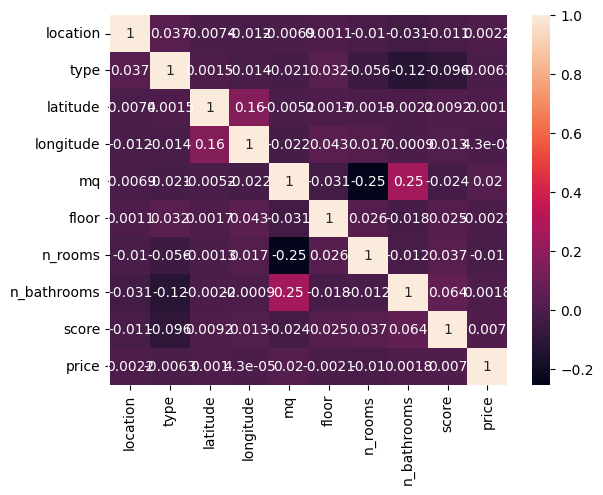

In [23]:
cor = train_df.corr()
sns.heatmap(cor, annot = True)

In [24]:
from sklearn.feature_selection import SelectKBest, chi2

# start time
start_time_forward = time.time()

### Applying feature selection method
chi2_selector = SelectKBest(score_func=chi2, k=6)  # change k
chi2_selector.fit_transform(X_train, y_train)

# end time
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward

# show feature selection
selected_features = chi2_selector.get_support()
print('The selected features are:', list(X_train.columns[selected_features]))

# show elapsed time of this method
print(f"Execution time: {time_forward:.2f} seconds")

The selected features are: ['location', 'type', 'latitude', 'longitude', 'mq', 'score']
Execution time: 0.31 seconds


De la *Correlación de Pearson* podemos ver que prácticamente ninguna variable está altamente correlacionada. Solo podemos notar una ligera dependencia entre las dimensiones de la vivienda y la cantidad de baños. Tal vez lo que pudimos esperar es que *floor*, *n_rooms* y *n_bathrooms* estuvieran relacionadas a *mq*, pero no parece ser así dentro de los registros del dataset de entrenamiento. Por otra parte, el método de *Chi2* sí nos dice que *mq* tiene más relevancia que *floor*, *n_rooms* y *n_bathrooms*, y de hecho el orden de importancia de las características es algo que hace sentido a la intuición, siendo principalmente *location* el que defina el precio de las viviendas, seguido por el tipo de vivienda, la ubicación y las dimensiones.

Dicho esto, descartaremos *floor*, *n_rooms* y *n_bathrooms*, para quedarnos con 6 variables:

In [25]:
X_train = X_train.drop(['floor', 'n_rooms', 'n_bathrooms'], axis=1)

## Reducción de dimensionalidad

Para la reducción de dimensionalidad usaremos *LDA*, ya que es un método supervisado y no contamos con mucho recurso computacional:

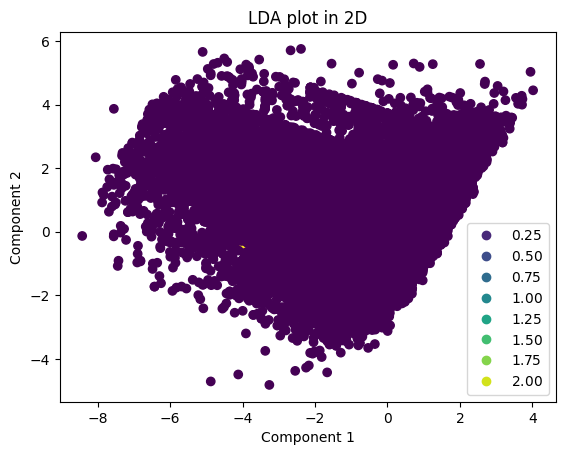

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X_LDA = LDA(n_components = 2).fit_transform(X_train, y_train)

scatter = plt.scatter(X_LDA[:, 0], X_LDA[:, 1], c = y_train)
plt.title('LDA plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

De lo que se puede apreciar de esta transformación podemos anticiparnos a que un modelo de regresión lineal no nos va a servir mucho para pronosticar los precios, ya que al parecer *LDA* no está separando bien los datos de entrenamiento. Habría que intentar con alternativas de modelos multivariables para ver si dan un mejor rendimiento que lo que se pronostica para el modelo de regresión lineal

## Modelos de regresión

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [28]:
train_LDA = pd.concat([pd.Series(X_LDA[:,0], name='X_LDA'), pd.Series(X_LDA[:,1], name='y_LDA')], axis=1)

#Regresión Lineal
linear_reg = LinearRegression()
linear_reg.fit(train_LDA[['X_LDA']], train_LDA['y_LDA'])

#Regresión Multivariable
Multi_reg = LinearRegression()
Multi_reg.fit(X_train, y_train)

#Regresión Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

#Regresión Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

#y_pred_LDA = linear_reg.predict(X_test_LDA)
#print(f'R^2: {r2_score(y_test_LDA, y_pred_LDA)}')

C:\Users\Black\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.46433e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RandomForestRegressor(random_state=42)

## Evaluación con datos locales

In [29]:
y_train_pred = pd.concat([pd.Series(linear_reg.predict(train_LDA[['X_LDA']]), name = 'lineal'), 
                    pd.Series(Multi_reg.predict(X_train), name = 'multivariable'), 
                    pd.Series(ridge_reg.predict(X_train), name = 'ridge'), 
                    pd.Series(rf_reg.predict(X_train), name = 'randomForest')], axis = 1)

In [30]:
train_score = [
    r2_score(train_LDA['y_LDA'], y_train_pred['lineal']),
    r2_score(y_train, y_train_pred['multivariable']),
    r2_score(y_train, y_train_pred['ridge']),
    r2_score(y_train, y_train_pred['randomForest'])
]

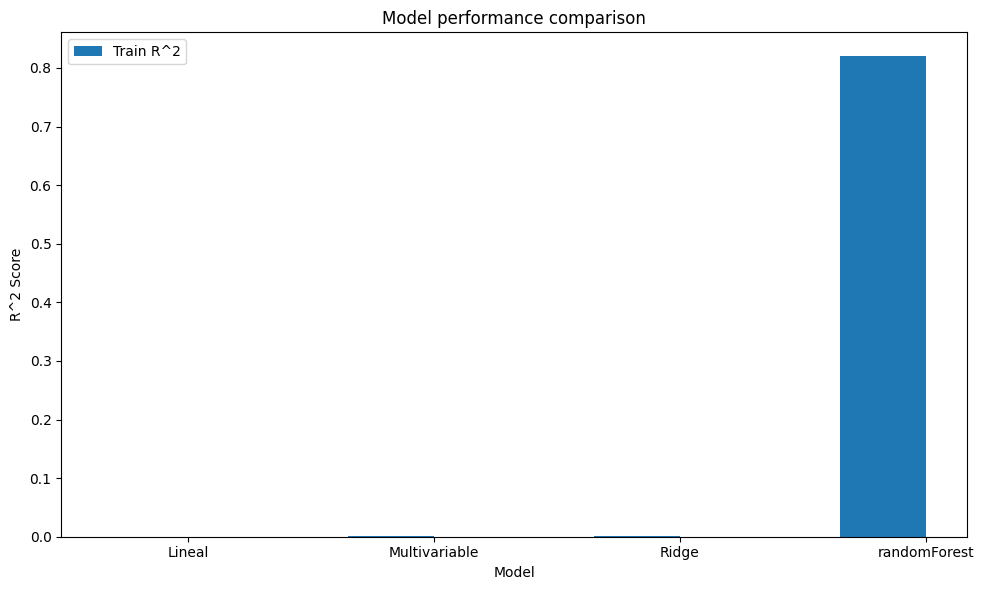

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(['Lineal', 'Multivariable', 'Ridge', 'randomForest']))
bar_width = 0.35

bar = ax.bar(index, train_score, bar_width, label='Train R^2')

ax.set_xlabel('Model')
ax.set_ylabel('R^2 Score')
ax.set_title('Model performance comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Lineal', 'Multivariable', 'Ridge', 'randomForest'])
ax.legend()

plt.tight_layout()
plt.show()

## Evaluación con datos de prueba

In [32]:
test_df = pd.read_csv(f'test_housing_data_italy.csv', na_values=r'\N')

list(test_df.columns.values)

['timestamp',
 'location',
 'title',
 'price',
 'n_rooms',
 'floor',
 'mq',
 'n_bathrooms',
 'year_of_construction',
 'availability',
 'energy_class',
 'status',
 'heating',
 'has_garage',
 'has_terrace',
 'has_garden',
 'has_balcony',
 'has_fireplace',
 'has_alarm',
 'has_air_conditioning',
 'has_pool',
 'has_parking',
 'has_elevator',
 'is_furnished',
 'latitude',
 'longitude']

In [33]:
test_df = pd.read_csv(f'test_housing_data_italy.csv', na_values=r'\N')

test_df['location'] = [cities.index(x) if x in cities else -1 for x in test_df['location']]
test_df['location'] = test_df['location'].astype('category')

test_df['title'] = test_df['title'].str.split(' ').str[0]
test_df['title'] = test_df['title'].str.replace(',', '')
test_df = test_df.rename(columns={'title':'type'})
test_df['type'] = [types.index(x) if x in types else -1 for x in test_df['type']]
test_df['type'] = test_df['type'].astype('category')

test_df = test_df.fillna({'price': 0})

test_df = test_df.fillna({'n_rooms': 1})
test_df['n_rooms'] = test_df['n_rooms'].astype('int64')

newDimension = 28 + 10 * (test_df['n_rooms'] -1)
test_df['mq'] = test_df['mq'].fillna(value = newDimension)

test_df = test_df.fillna({'year_of_construction': 0})
test_df.loc[test_df['year_of_construction'] < 1990, 'year_of_construction'] = 0
test_df.loc[test_df['year_of_construction'] > 0, 'year_of_construction'] = 1
test_df = test_df.rename(columns={'year_of_construction':'is_modern'})

test_df.loc[test_df['heating'] == 'autonomous', 'heating'] = 0
test_df.loc[test_df['heating'] == 'other', 'heating'] = 1

test_df = test_df.fillna({'latitude': '0.0.0'})
coord = test_df['latitude'].str.split(pat=".")
coord = ["".join(x) for x in coord]
coord = [int(x) for x in coord]
test_df['latitude'] = coord

test_df = test_df.fillna({'longitude': '0.0.0'})
coord = test_df['longitude'].str.split(pat=".")
coord = ["".join(x) for x in coord]
coord = [int(x) for x in coord]
test_df['longitude'] = coord

test_df['score'] = (test_df['is_modern'] + test_df['heating'] + test_df['has_garage'] + test_df['has_terrace'] + test_df['has_garden'] 
                     + test_df['has_balcony'] + test_df['has_fireplace'] + test_df['has_alarm'] + test_df['has_air_conditioning'] 
                     + test_df['has_pool'] + test_df['has_parking'] + test_df['has_elevator'] + test_df['is_furnished'])

test_df['score'] = test_df['score'].astype('int64')

test_df = test_df.drop(['timestamp', 'n_rooms', 'floor', 'n_bathrooms', 'is_modern', 'availability', 'energy_class', 'status', 
                        'heating', 'has_garage', 'has_terrace', 'has_garden', 'has_balcony', 'has_fireplace', 'has_alarm', 
                        'has_air_conditioning', 'has_pool', 'has_parking', 'has_elevator', 'is_furnished'], axis=1)

In [34]:
test_df = test_df.iloc[:,[0, 1, 4, 5, 3, 6, 2]]

In [35]:
X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]
test_X_LDA = LDA(n_components = 2).fit_transform(X_test, y_test)

test_LDA = pd.concat([pd.Series(test_X_LDA[:,0], name='X_LDA'), pd.Series(test_X_LDA[:,1], name='y_LDA')], axis=1)


In [36]:
y_test_pred = pd.concat([pd.Series(linear_reg.predict(test_LDA[['X_LDA']]), name = 'lineal'), 
                    pd.Series(Multi_reg.predict(X_test), name = 'multivariable'), 
                    pd.Series(ridge_reg.predict(X_test), name = 'ridge'), 
                    pd.Series(rf_reg.predict(X_test), name = 'randomForest')], axis = 1)

In [37]:
test_score = [
    r2_score(test_LDA['y_LDA'], y_test_pred['lineal']),
    r2_score(y_test, y_test_pred['multivariable']),
    r2_score(y_test, y_test_pred['ridge']),
    r2_score(y_test, y_test_pred['randomForest'])
]

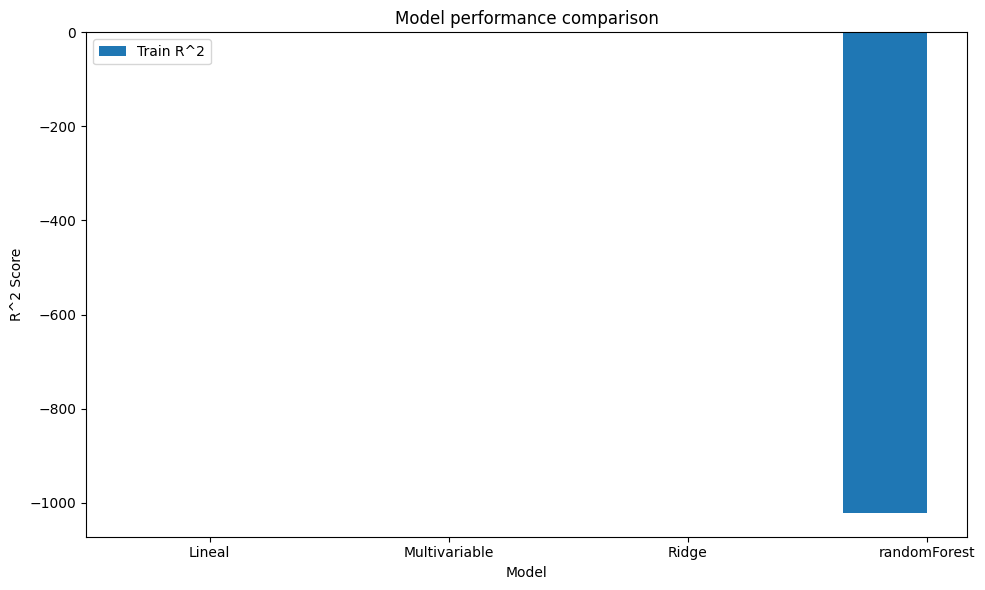

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(['Lineal', 'Multivariable', 'Ridge', 'randomForest']))
bar_width = 0.35

bar = ax.bar(index, test_score, bar_width, label='Train R^2')

ax.set_xlabel('Model')
ax.set_ylabel('R^2 Score')
ax.set_title('Model performance comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Lineal', 'Multivariable', 'Ridge', 'randomForest'])
ax.legend()

plt.tight_layout()
plt.show()

In [39]:
test_score

[0.0, -0.02249264808081297, -0.0225660068148974, -1021.4527532858108]